# Running a full NEB workflow for migration energy barrier calculations with NEB and MACE

This tutorial shows how to run a vacancy diffusion workflow using the Forge Package. 

The workflow is as follows:
1. Create a random alloy composition
2. Run Monte Carlo to get an energetically favorable order for the structure
3. Relax the alloy structure and it's cell
4. Pick a vacancy index randomly from the structure
5. Sample the nearest and next nearest neighbors of the vacancy
6. Run the vacancy diffusion using the DyNEB method on the vacancy and the target index (picked at random from the nearest neighbors)
7. Relax the vacancy start and end points (handled in the VacancyDiffusion object)
8. Run the NEB simulation 
9. Plot the migration energy barrier


## Loading the necessary packages and modules for FORGE

In [1]:
import numpy as np 

from ase.build import bulk 
from forge.workflows.mcmc import MonteCarloAlloySampler
from mace.calculators.mace import MACECalculator 

# For Step 1, getting the composition we want. 
from forge.analysis.composition import CompositionAnalyzer
from math import ceil, floor

# For checking the device and getting absolute paths
import forge 
import torch
from pathlib import Path


# For creating the vacancy diffusion object in step 4-9
from forge.workflows.neb import VacancyDiffusion

# For plotting the scaled energies
import matplotlib.pyplot as plt

/home/myless/.miniforge3/envs/forge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/myless/.miniforge3/envs/forge/lib/python3.11/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializat

## Creating the composition and initializing the random alloy structure

In [2]:
# set all the seeds
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


In [3]:
N = 6 # sets the size of the supercell
num_atoms = 2*N**3

# Get the atomic fractions for the alloy correctly rounded to 4 decimal places for the given super cell size
x_zr = round(ceil(0.0025 * num_atoms)/num_atoms, 4)
x_cr = round(ceil(0.04 * num_atoms)/num_atoms, 4)
x_ti = round(ceil(0.05 * num_atoms)/num_atoms, 4)
x_w = round(ceil(0.05 * num_atoms)/num_atoms, 4)
x_v = round(1 - x_zr - x_cr - x_ti - x_w, 4)

# Adjust x_v if the sum of the composition is not 1
if x_zr + x_cr + x_ti + x_w + x_v != 1:
    x_v = 1 - x_zr - x_cr - x_ti - x_w
    
composition = {
    'V' : x_v,
    'Cr' : x_cr,
    'Ti' : x_ti,
    'W' : x_w,
    'Zr' : x_zr
}

print(f"The Composition of our alloy is {composition}")

The Composition of our alloy is {'V': 0.8519, 'Cr': 0.0417, 'Ti': 0.0509, 'W': 0.0509, 'Zr': 0.0046}


Now we will create the randomly ordered alloy structure using the CompositionAnalyzer class. This creates an ASE atoms object. 

In [4]:
analyzer = CompositionAnalyzer()
atoms = analyzer.create_random_alloy(composition = composition, 
                                         crystal_type = 'bcc', 
                                         dimensions=[N,N,N], 
                                         lattice_constant = 3.01,
                                         balance_element = 'V', 
                                         cubic=True)

print(atoms)

Atoms(symbols='Cr19Ti22V367W22Zr2', pbc=True, cell=[18.06, 18.06, 18.06])


## Ordering and then Relaxing the alloy structure and it's cell

For this step, we will load the MACE model we want to use, run the Monte Carlo to get an energetically favorable order for the structure, and then relax the alloy structure and it's cell. 

In [15]:
# The model path should point to your MACE model that you want to use.
model_path = '../potentials/gen_6_model_0_L0_isolated-2026-01-16_stagetwo.model'

# This is some boiler plate code to check the device and enable CUEQ if we are using a GPU.
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    enable_cueq = True
else:
    enable_cueq = False

# Define the mace calculator
calc = MACECalculator(model_paths=[model_path],
                      device=device,
                      default_dtype="float32",
                      enable_cueq=enable_cueq)

# Attach the calculator to the atoms object
atoms.calc = calc

# Define the temperature and the number of steps per atom
temperature = 600+273.15
steps_per_atom = 100 # in this test we do only 1, in real life you want to do 50-100 steps per atom
total_swaps = steps_per_atom * len(atoms)

# Define the Monte Carlo sampler object
mc_sampler = MonteCarloAlloySampler(
    atoms=atoms,
    calculator=calc,
    temperature=temperature,
    steps=total_swaps,
)

# Run the Monte Carlo sampler
final_atoms = mc_sampler.run_mcmc()


Converting models to CuEq for acceleration


/home/myless/.miniforge3/envs/forge/lib/python3.11/site-packages/mace/modules/models.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "atomic_numbers", torch.tensor(atomic_numbers, dtype=torch.int64)
Running MC: 100%|██████████| 43200/43200 [05:30<00:00, 130.88steps/s, energy=-3947.433 eV, Δe/atom=0.003134 eV]


In [16]:
# you can save the final atoms to a file if you want
final_atoms.write(f'{final_atoms.get_chemical_formula()}_relaxed.xyz')


Here we use a wrapper for the ASE relaxation function to relax the structure and it's cell. 

In [23]:
# take in the final atoms and relax the structure 
from forge.workflows.relax import relax 

relaxed_atoms = relax(atoms = final_atoms, 
                     calculator = calc, 
                     relax_cell = True, 
                     fmax = 0.04, 
                     steps = 100, 
                     optimizer = "FIRE",
                     verbose = 1,
                     interval = 0)



INFO:forge.workflows.relax:Relaxing atomic positions and unit cell
INFO:forge.workflows.relax:Starting optimization with FIRE, fmax=0.04, max steps=100


      Step     Time          Energy          fmax
FIRE:    0 01:04:09    -3947.433105        1.369990


INFO:forge.workflows.relax:Energy: -3947.433105 eV, Max force: 0.961682 eV/Å


FIRE:    1 01:04:09    -3948.198975        1.231775
FIRE:    2 01:04:09    -3949.443359        0.978675
FIRE:    3 01:04:09    -3950.573730        0.698263
FIRE:    4 01:04:09    -3951.374756        0.438745
FIRE:    5 01:04:09    -3951.868896        0.311649
FIRE:    6 01:04:09    -3952.081299        0.299395
FIRE:    7 01:04:09    -3952.048340        0.382120
FIRE:    8 01:04:09    -3952.061768        0.370055
FIRE:    9 01:04:09    -3952.088867        0.346437
FIRE:   10 01:04:09    -3952.121826        0.312232
FIRE:   11 01:04:09    -3952.165039        0.268907
FIRE:   12 01:04:09    -3952.208008        0.218320
FIRE:   13 01:04:09    -3952.248535        0.162889
FIRE:   14 01:04:09    -3952.281250        0.120064
FIRE:   15 01:04:09    -3952.309570        0.092749
FIRE:   16 01:04:09    -3952.328369        0.093285
FIRE:   17 01:04:09    -3952.333984        0.109412
FIRE:   18 01:04:09    -3952.334961        0.107855
FIRE:   19 01:04:09    -3952.336182        0.104768
FIRE:   20 0

INFO:forge.workflows.relax:Optimization completed after 48 steps
INFO:forge.workflows.relax:Final energy: -3952.462402 eV
INFO:forge.workflows.relax:Maximum force: 0.035094 eV/Å


## Creating the vacancy diffusion object and running the vacancy diffusion NEB calculation

This step creates the VacancyDiffusion object and runs the vacancy diffusion NEB calculation on a single vacancy and target index. 

In [24]:
# create the VacancyDiffusion object

neb = VacancyDiffusion(atoms = relaxed_atoms,
                       model_path = model_path
                       )



In this block we show how to extract the nearest and next nearest neighbors of the vacancy index. You can use the .sample_neighbors method from the VacancyDiffusion object to get the neighbors. It returns a dictionary with the vacancy index, the nearest neighbors, and the next nearest neighbors. 

In [25]:
from pathlib import Path

# get the vacancy index randomly from the len of atoms
vac_idx = np.random.randint(0, len(atoms))

print(f"Vacancy index: {vac_idx}")

# get the neighbors of the vacancy index, #TODO separate the nearest and next nearest neighbors results, maybe using a dictionary 
neighbors = neb.sample_neighbors(vacancy_indices=[vac_idx], n_nearest=8, n_next_nearest=1)

# print the neighbors
print(f"Neighbors: {neighbors}")

# get the target index from the neighbors
tar_idx = neighbors[0]

print(f"Target index: {tar_idx}")


Vacancy index: 102
Neighbors: [{'vacancy_index': 102, 'nn': [17, 19, 89, 101, 31, 91, 103, 29], 'nnn': [90]}]
Target index: {'vacancy_index': 102, 'nn': [17, 19, 89, 101, 31, 91, 103, 29], 'nnn': [90]}


To test how a single vacancy diffusion calculation works, we will run the vacancy diffusion calculation on the vacancy index and the target index (we just pick the first nearest neighbor). You can change the number of images, the neb method (although DyNEB is the fastest with no change in the barrier compared to VASP), whether or not we use climbing image (which is the default), and the relaxation parameters. Additionally you can change the seed for the random number generator, save the initial trajectory for debugging, and set the output directory to save the results. 

In [26]:
# run the vacancy diffusion
results = neb.run_single(vacancy_index=vac_idx,
               target_index=tar_idx['nn'][0],
               num_images=5,
               neb_method="dyneb",
               climb=True,
               save_xyz=True,
               neb_fmax=0.04,
               neb_steps=200,
               verbose=1,
               output_dir=Path(".")
               )

INFO:forge.workflows.relax:Relaxing atomic positions with fixed unit cell
INFO:forge.workflows.relax:Starting optimization with FIRE, fmax=0.01, max steps=100


      Step     Time          Energy          fmax
FIRE:    0 01:04:38    -3940.233887        0.698034


INFO:forge.workflows.relax:Energy: -3940.233887 eV, Max force: 0.460185 eV/Å


FIRE:    1 01:04:38    -3940.254395        0.644990
FIRE:    2 01:04:38    -3940.289551        0.544573
FIRE:    3 01:04:38    -3940.336426        0.440727
FIRE:    4 01:04:38    -3940.381348        0.366760
FIRE:    5 01:04:38    -3940.421875        0.277673
FIRE:    6 01:04:38    -3940.453613        0.180132
FIRE:    7 01:04:38    -3940.469238        0.199735
FIRE:    8 01:04:38    -3940.474609        0.272271
FIRE:    9 01:04:38    -3940.476074        0.265094
FIRE:   10 01:04:38    -3940.478027        0.250950


INFO:forge.workflows.relax:Energy: -3940.478027 eV, Max force: 0.175659 eV/Å


FIRE:   11 01:04:38    -3940.479004        0.230274
FIRE:   12 01:04:38    -3940.481934        0.203726
FIRE:   13 01:04:38    -3940.485840        0.172172
FIRE:   14 01:04:38    -3940.487793        0.136744
FIRE:   15 01:04:38    -3940.490723        0.098831
FIRE:   16 01:04:38    -3940.493652        0.068731
FIRE:   17 01:04:38    -3940.494141        0.072938
FIRE:   18 01:04:38    -3940.495117        0.086960
FIRE:   19 01:04:38    -3940.496582        0.099034
FIRE:   20 01:04:38    -3940.497070        0.106318


INFO:forge.workflows.relax:Energy: -3940.497070 eV, Max force: 0.067168 eV/Å


FIRE:   21 01:04:38    -3940.496094        0.105411
FIRE:   22 01:04:38    -3940.495605        0.103612
FIRE:   23 01:04:38    -3940.496094        0.100948
FIRE:   24 01:04:38    -3940.496582        0.097486
FIRE:   25 01:04:38    -3940.497559        0.093269
FIRE:   26 01:04:39    -3940.497559        0.088390
FIRE:   27 01:04:39    -3940.498535        0.082948
FIRE:   28 01:04:39    -3940.498047        0.076424
FIRE:   29 01:04:39    -3940.499512        0.068831
FIRE:   30 01:04:39    -3940.498047        0.060336


INFO:forge.workflows.relax:Energy: -3940.498047 eV, Max force: 0.037151 eV/Å


FIRE:   31 01:04:39    -3940.499023        0.051402
FIRE:   32 01:04:39    -3940.498047        0.042772
FIRE:   33 01:04:39    -3940.499023        0.048348
FIRE:   34 01:04:39    -3940.500000        0.053850
FIRE:   35 01:04:39    -3940.500488        0.052496
FIRE:   36 01:04:39    -3940.502441        0.043622
FIRE:   37 01:04:39    -3940.502930        0.029283
FIRE:   38 01:04:39    -3940.504395        0.029371
FIRE:   39 01:04:39    -3940.505371        0.033758
FIRE:   40 01:04:39    -3940.506348        0.036181


INFO:forge.workflows.relax:Energy: -3940.506348 eV, Max force: 0.021308 eV/Å


FIRE:   41 01:04:39    -3940.506348        0.034084
FIRE:   42 01:04:39    -3940.507324        0.026844
FIRE:   43 01:04:39    -3940.508301        0.016793
FIRE:   44 01:04:39    -3940.509277        0.012066
FIRE:   45 01:04:39    -3940.508789        0.010072
FIRE:   46 01:04:39    -3940.510254        0.010915
FIRE:   47 01:04:39    -3940.512695        0.012392
FIRE:   48 01:04:39    -3940.513672        0.012799
FIRE:   49 01:04:39    -3940.515625        0.013874
FIRE:   50 01:04:39    -3940.516602        0.015811


INFO:forge.workflows.relax:Energy: -3940.516602 eV, Max force: 0.010635 eV/Å


FIRE:   51 01:04:39    -3940.518799        0.023514
FIRE:   52 01:04:39    -3940.521973        0.033345
FIRE:   53 01:04:39    -3940.527100        0.040353
FIRE:   54 01:04:39    -3940.529785        0.121944
FIRE:   55 01:04:40    -3940.487061        0.688273
FIRE:   56 01:04:40    -3940.520508        0.562028
FIRE:   57 01:04:40    -3940.540527        0.309178
FIRE:   58 01:04:40    -3940.549805        0.108396
FIRE:   59 01:04:40    -3940.550781        0.108919
FIRE:   60 01:04:40    -3940.551270        0.109979


INFO:forge.workflows.relax:Energy: -3940.551270 eV, Max force: 0.065370 eV/Å


FIRE:   61 01:04:40    -3940.551758        0.111582
FIRE:   62 01:04:40    -3940.552002        0.113732
FIRE:   63 01:04:40    -3940.552734        0.116417
FIRE:   64 01:04:40    -3940.553223        0.119596
FIRE:   65 01:04:40    -3940.553955        0.123250
FIRE:   66 01:04:40    -3940.556152        0.127893
FIRE:   67 01:04:40    -3940.558594        0.133952
FIRE:   68 01:04:40    -3940.559570        0.142162
FIRE:   69 01:04:40    -3940.563965        0.153682
FIRE:   70 01:04:40    -3940.568848        0.170108


INFO:forge.workflows.relax:Energy: -3940.568848 eV, Max force: 0.101138 eV/Å


FIRE:   71 01:04:40    -3940.574219        0.193636
FIRE:   72 01:04:40    -3940.583008        0.227246
FIRE:   73 01:04:40    -3940.597656        0.274332
FIRE:   74 01:04:40    -3940.620605        0.336326
FIRE:   75 01:04:40    -3940.660156        0.404369
FIRE:   76 01:04:40    -3940.723389        0.444023
FIRE:   77 01:04:40    -3940.813477        0.456201
FIRE:   78 01:04:40    -3940.929443        0.605105
FIRE:   79 01:04:40    -3941.076660        0.783319
FIRE:   80 01:04:40    -3941.250000        0.836781


INFO:forge.workflows.relax:Energy: -3941.250000 eV, Max force: 0.544283 eV/Å


FIRE:   81 01:04:40    -3941.422852        0.709770
FIRE:   82 01:04:40    -3941.545166        0.327513
FIRE:   83 01:04:40    -3941.572021        0.364387
FIRE:   84 01:04:41    -3941.593262        0.225181
FIRE:   85 01:04:41    -3941.610840        0.093821
FIRE:   86 01:04:41    -3941.611816        0.181575
FIRE:   87 01:04:41    -3941.614746        0.164967
FIRE:   88 01:04:41    -3941.617188        0.134173
FIRE:   89 01:04:41    -3941.622070        0.094079
FIRE:   90 01:04:41    -3941.622559        0.053406


INFO:forge.workflows.relax:Energy: -3941.622559 eV, Max force: 0.042174 eV/Å


FIRE:   91 01:04:41    -3941.624023        0.057800
FIRE:   92 01:04:41    -3941.623535        0.058360
FIRE:   93 01:04:41    -3941.624512        0.055717
FIRE:   94 01:04:41    -3941.623779        0.050575
FIRE:   95 01:04:41    -3941.623047        0.044291
FIRE:   96 01:04:41    -3941.624023        0.037372
FIRE:   97 01:04:41    -3941.623047        0.031887
FIRE:   98 01:04:41    -3941.624023        0.026726
FIRE:   99 01:04:41    -3941.625977        0.023216
FIRE:  100 01:04:41    -3941.625488        0.020725


INFO:forge.workflows.relax:Energy: -3941.625488 eV, Max force: 0.015728 eV/Å
INFO:forge.workflows.relax:Optimization completed after 100 steps
INFO:forge.workflows.relax:Final energy: -3941.625488 eV
INFO:forge.workflows.relax:Maximum force: 0.015728 eV/Å
INFO:forge.workflows.relax:Relaxing atomic positions with fixed unit cell
INFO:forge.workflows.relax:Starting optimization with FIRE, fmax=0.01, max steps=100


      Step     Time          Energy          fmax
FIRE:    0 01:04:41    -3940.248047        0.722941


INFO:forge.workflows.relax:Energy: -3940.248047 eV, Max force: 0.424296 eV/Å


FIRE:    1 01:04:41    -3940.270996        0.673613
FIRE:    2 01:04:41    -3940.311035        0.580582
FIRE:    3 01:04:41    -3940.363281        0.453758
FIRE:    4 01:04:41    -3940.416992        0.378699
FIRE:    5 01:04:41    -3940.465332        0.341097
FIRE:    6 01:04:41    -3940.502441        0.283869
FIRE:    7 01:04:41    -3940.523926        0.203895
FIRE:    8 01:04:41    -3940.532227        0.220565
FIRE:    9 01:04:42    -3940.531250        0.214144
FIRE:   10 01:04:42    -3940.532471        0.201484


INFO:forge.workflows.relax:Energy: -3940.532471 eV, Max force: 0.126315 eV/Å


FIRE:   11 01:04:42    -3940.534668        0.182965
FIRE:   12 01:04:42    -3940.537109        0.159141
FIRE:   13 01:04:42    -3940.539551        0.130784
FIRE:   14 01:04:42    -3940.542725        0.098812
FIRE:   15 01:04:42    -3940.543945        0.076329
FIRE:   16 01:04:42    -3940.546387        0.069915
FIRE:   17 01:04:42    -3940.547852        0.062287
FIRE:   18 01:04:42    -3940.548340        0.056443
FIRE:   19 01:04:42    -3940.548828        0.088623
FIRE:   20 01:04:42    -3940.549316        0.087454


INFO:forge.workflows.relax:Energy: -3940.549316 eV, Max force: 0.052957 eV/Å


FIRE:   21 01:04:42    -3940.549316        0.085138
FIRE:   22 01:04:42    -3940.548828        0.081713
FIRE:   23 01:04:42    -3940.548828        0.077238
FIRE:   24 01:04:42    -3940.548828        0.071814
FIRE:   25 01:04:42    -3940.548828        0.065543
FIRE:   26 01:04:42    -3940.549805        0.058548
FIRE:   27 01:04:42    -3940.551270        0.050170
FIRE:   28 01:04:42    -3940.550781        0.040444
FIRE:   29 01:04:42    -3940.551270        0.039155
FIRE:   30 01:04:42    -3940.550781        0.037485


INFO:forge.workflows.relax:Energy: -3940.550781 eV, Max force: 0.024433 eV/Å


FIRE:   31 01:04:42    -3940.550781        0.035345
FIRE:   32 01:04:42    -3940.550293        0.032681
FIRE:   33 01:04:42    -3940.550781        0.029450
FIRE:   34 01:04:42    -3940.550781        0.025664
FIRE:   35 01:04:42    -3940.553223        0.022342
FIRE:   36 01:04:42    -3940.552734        0.019180
FIRE:   37 01:04:43    -3940.552246        0.014494
FIRE:   38 01:04:43    -3940.553711        0.012042
FIRE:   39 01:04:43    -3940.554199        0.020494
FIRE:   40 01:04:43    -3940.553223        0.021446


INFO:forge.workflows.relax:Energy: -3940.553223 eV, Max force: 0.013636 eV/Å


FIRE:   41 01:04:43    -3940.554199        0.013764
FIRE:   42 01:04:43    -3940.554688        0.009630


INFO:forge.workflows.relax:Optimization completed after 42 steps
INFO:forge.workflows.relax:Final energy: -3940.554688 eV
INFO:forge.workflows.relax:Maximum force: 0.008501 eV/Å


      Step     Time          Energy          fmax
FIRE:    0 01:04:44    -3939.327637        0.960156
FIRE:    1 01:04:44    -3939.386719        0.786313
FIRE:    2 01:04:44    -3939.479492        0.657183
FIRE:    3 01:04:45    -3939.580566        0.549056
FIRE:    4 01:04:45    -3939.661621        0.431732
FIRE:    5 01:04:45    -3939.716309        0.448050
FIRE:    6 01:04:45    -3939.747070        0.496056
FIRE:    7 01:04:45    -3939.765137        0.382795
FIRE:    8 01:04:45    -3939.769043        0.291135
FIRE:    9 01:04:46    -3939.771973        0.282689
FIRE:   10 01:04:46    -3939.776855        0.266080
FIRE:   11 01:04:46    -3939.783203        0.241864
FIRE:   12 01:04:46    -3939.789551        0.210850
FIRE:   13 01:04:46    -3939.797852        0.174626
FIRE:   14 01:04:46    -3939.803711        0.138191
FIRE:   15 01:04:47    -3939.810547        0.119888
FIRE:   16 01:04:47    -3939.815918        0.098873
FIRE:   17 01:04:47    -3939.821289        0.098550
FIRE:   18 01:

Note on a 3090 this takes about 10 seconds to run on a 432 atom structure with 5 images. That would take about 1000 GPU hours (with an H100) to run using VASP!

In [27]:
# here is the output of the single vacancy diffusion calculation
results

{'vacancy_element': 'V',
 'target_element': 'V',
 'vacancy_index': '102',
 'target_index': '17',
 'barrier': 0.381591796875,
 'energies': [-3940.234375,
  -3940.40185546875,
  -3940.05810546875,
  -3939.852783203125,
  -3940.064453125,
  -3940.451171875,
  -3940.248046875],
 'converged': np.False_,
 'n_steps': 200,
 'success': True,
 'error': None,
 'is_nearest_neighbor': True}

Here is an example of how you can plot the energies from a single vacancy diffusion calculation. 

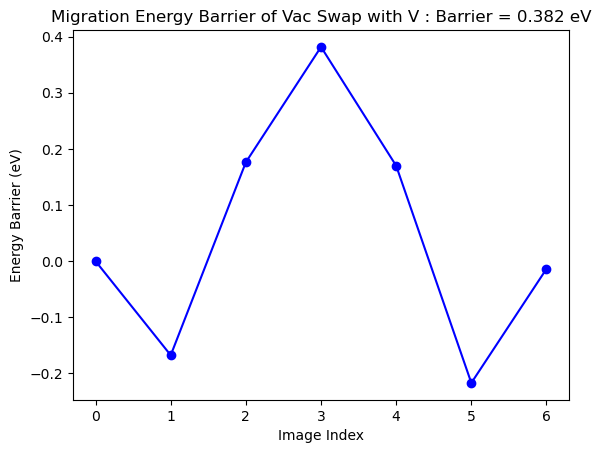

In [28]:
# Here we plot the relative energies of the vacancy diffusion calculation 
scaled_energies = [results['energies'][i] - results['energies'][0] for i in range(len(results['energies']))]

# plot the scaled energies
plt.plot(scaled_energies, marker='o', linestyle='-', color='b')
plt.xlabel('Image Index')
plt.ylabel('Energy Barrier (eV)')
plt.title(f'Migration Energy Barrier of Vac Swap with {results["target_element"]} : Barrier = {round(results["barrier"], 3)} eV')
plt.show()


## Running multiple vacancy diffusion calculations

For most vacancy diffusion calculations, you will want to run multiple vacancy diffusion calculations to infer the compositions potential energy landscape. Caution, this is best done on a GPU. Takes about 9 minutes on a 3090.

In [29]:
multi_neb = VacancyDiffusion(atoms=relaxed_atoms, model_path=model_path)

In [33]:
# pick 3 vacancy indices randomly from the len of atoms
multi_vac_indices = np.random.randint(0, len(atoms), int(len(atoms)/5)).tolist()

print(f"Vacancy indices: {multi_vac_indices}")

Vacancy indices: [350, 303, 270, 214, 251, 189, 295, 212, 207, 236, 337, 366, 52, 279, 409, 216, 251, 187, 379, 40, 156, 14, 300, 64, 344, 326, 8, 343, 128, 135, 62, 138, 80, 391, 162, 418, 288, 378, 260, 230, 40, 27, 134, 200, 327, 267, 417, 32, 47, 406, 61, 215, 292, 98, 171, 359, 213, 34, 226, 100, 430, 130, 256, 4, 217, 254, 397, 358, 282, 392, 206, 14, 345, 41, 379, 178, 62, 351, 230, 240, 51, 95, 387, 221, 406, 230]


In this multiple vacancy diffusion calculation, you can do the following:
- Change the number of images
- Change the neb method (although DyNEB is the fastest with no change in the barrier compared to VASP)
- Change whether or not we use climbing image (which is the default)
- Change the number of nearest and next nearest neighbors to sample at each vacancy index (default is 8 and 6 respectively)
- Change the relaxation parameters
- Change the seed for the random number generator
- Save the initial trajectory for debugging
- Set the output directory to save the results

This lets you create a results object that contains the vacancy diffusion calculations for each vacancy index. 

In [35]:
multi_neb_results = multi_neb.run_multiple(vacancy_indices=multi_vac_indices, 
                       num_images=5, 
                       neb_method='dyneb',
                       n_nearest=8,
                       n_next_nearest=6,
                       climb=True,
                       save_xyz=True,
                       output_dir=Path("./multi_vac_diff_results/"),
                       relax_fmax=0.04,
                       relax_steps=200,
                       neb_fmax=0.04,
                       neb_steps=200,
                       verbose=0,
                       rng_seed=seed
                       )



Starting 1203 NEB calculations...
Progress: 120/1203 calculations completed
Progress: 240/1203 calculations completed
Progress: 360/1203 calculations completed
Progress: 480/1203 calculations completed
Progress: 600/1203 calculations completed
Progress: 720/1203 calculations completed
Progress: 840/1203 calculations completed
Progress: 960/1203 calculations completed
Progress: 1080/1203 calculations completed
Progress: 1200/1203 calculations completed
Completed 1203 calculations


## Conducting analysis on multiple vacancy diffusion calculations

Once you have the results object, you can use the analyzer object to conduct analysis on the vacancy diffusion calculations. The analyzer object is created from the VacancyDiffusion object automatically. 

However you can manually create a new analyzer object from the results object if you'd like. 

Here we show how to plot the barrier distributions for the vacancy diffusion calculations. 

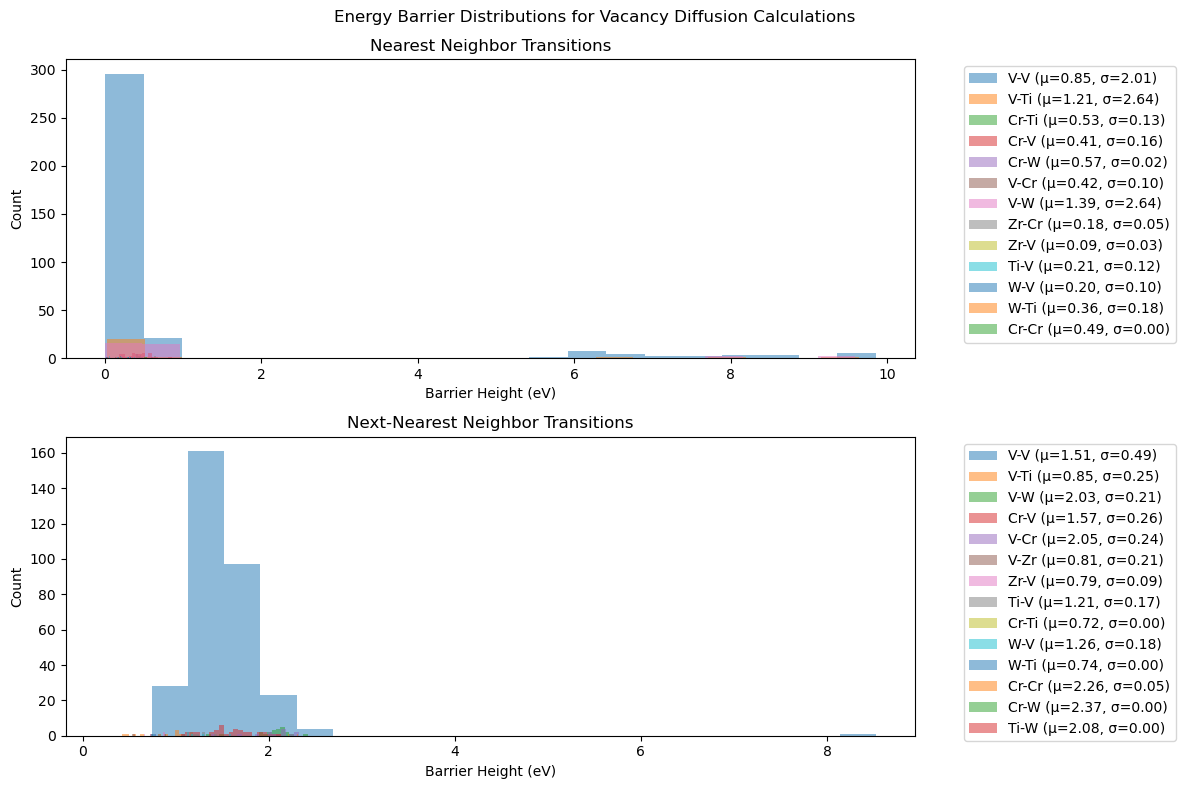

In [36]:
analyzer = multi_neb.analyzer

plot_dir = Path('./multi_vac_diff_results/barrier_plots')
plot_dir.mkdir(exist_ok=True)

# This plots the barrier distrutions for the vacancy diffusion calculations
analyzer.plot_barrier_distributions(save_path=plot_dir / 'barrier_distributions.png',
                                    bins=20,
                                    figsize=(12, 8),
                                    title="Energy Barrier Distributions for Vacancy Diffusion Calculations",
                                    show_stats=True,
                                    alpha=0.5,
                                    min_barrier=0.0,
                                    max_barrier=10.0)

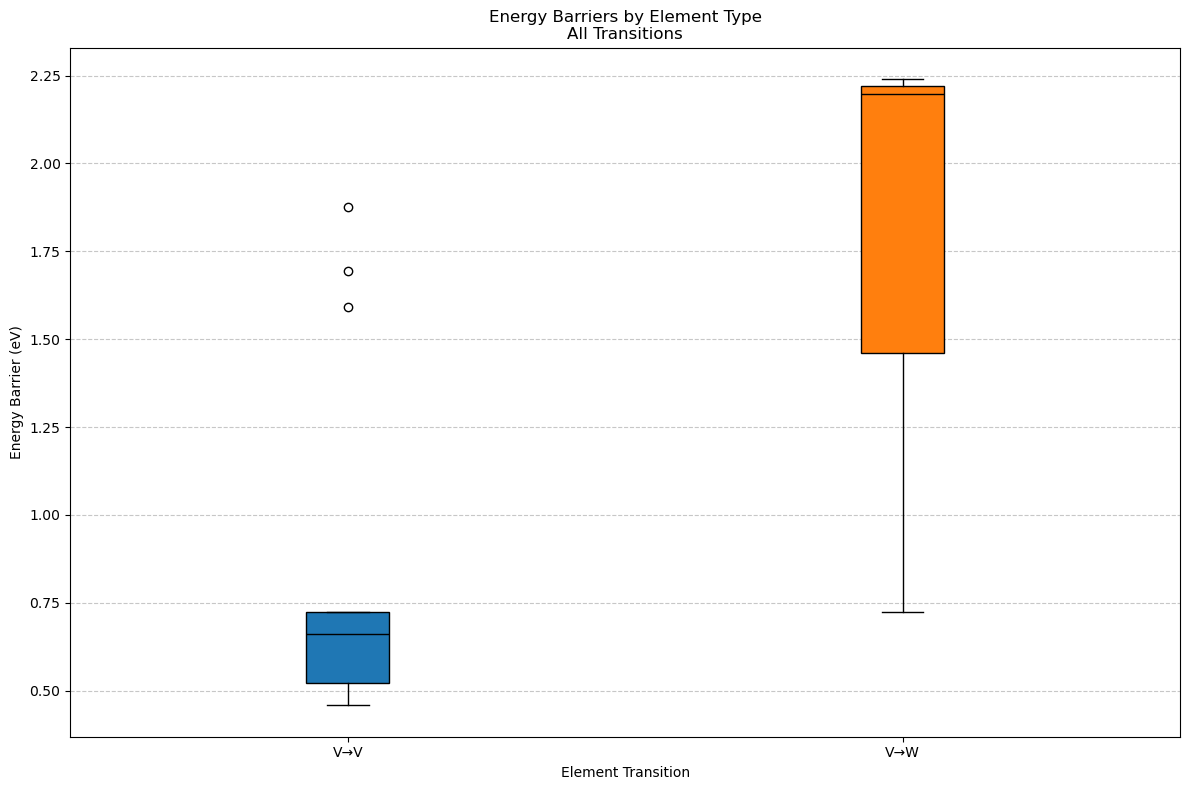

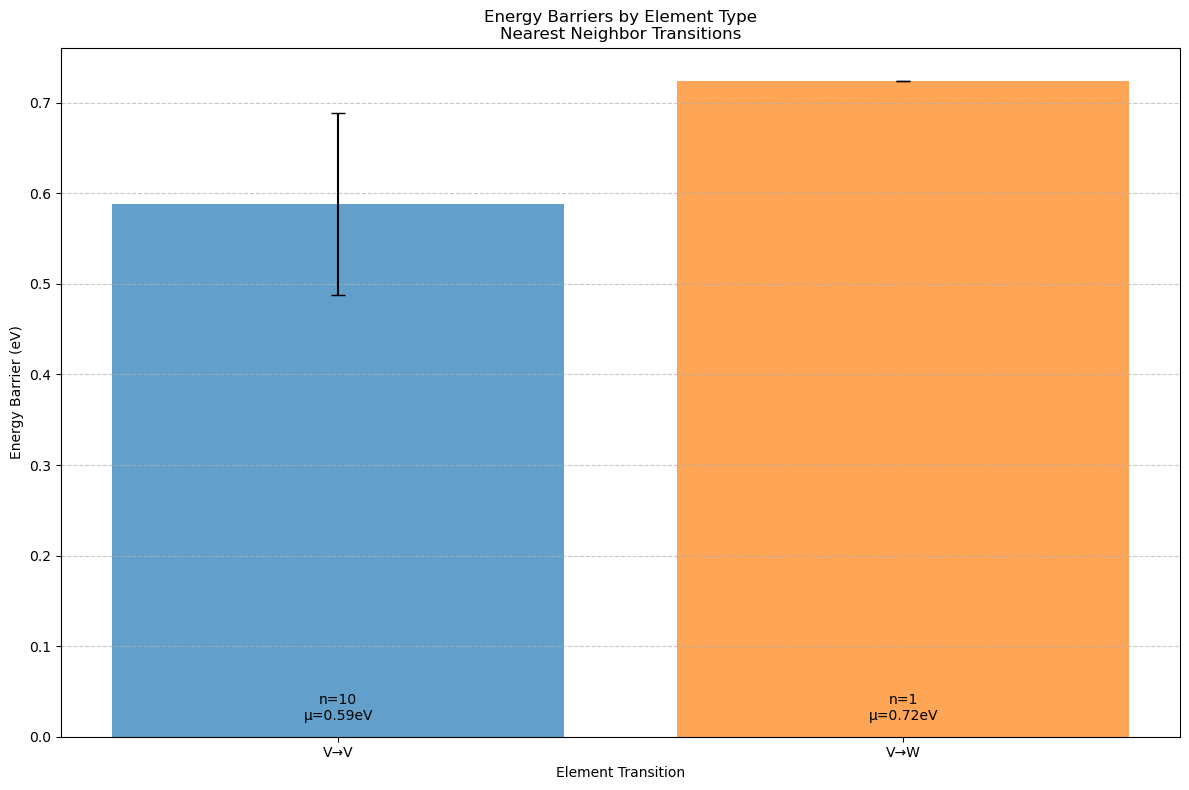

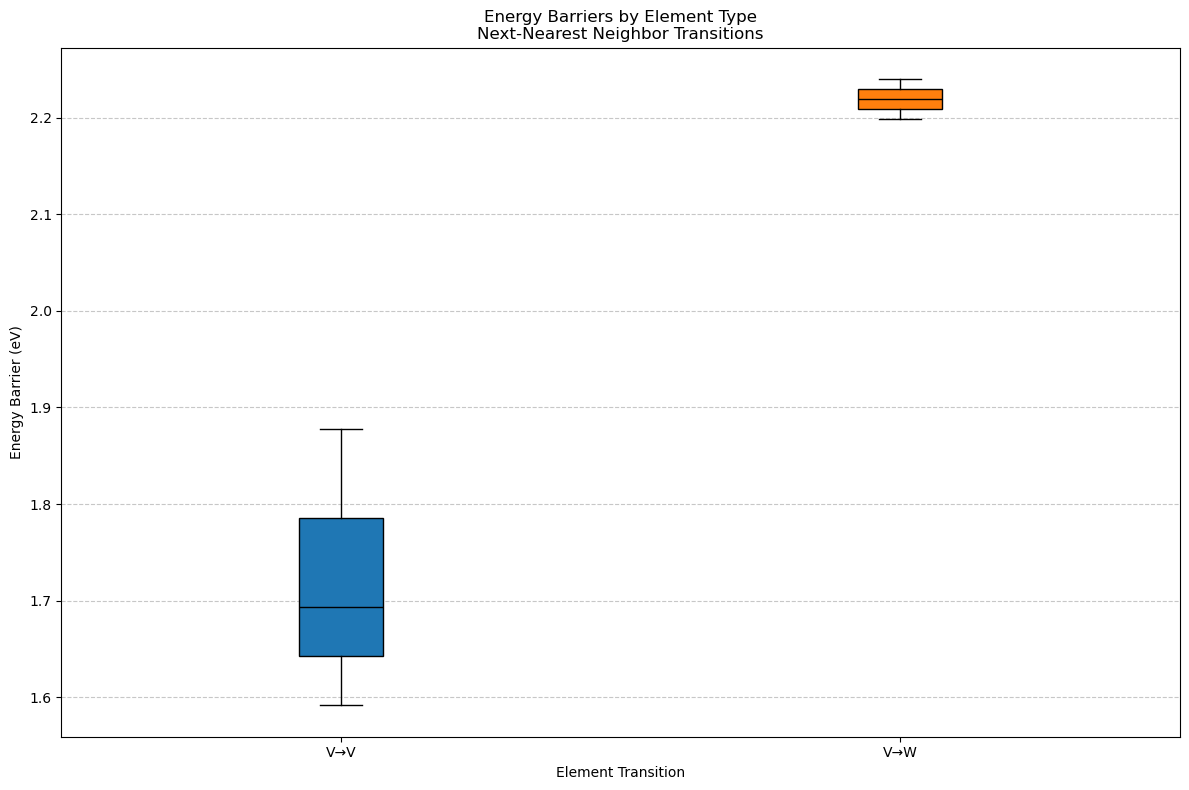

In [16]:
# Create a directory for plots if it doesn't exist
plot_dir = Path("./multi_vac_diff_results/barrier_plots_by_element")
plot_dir.mkdir(exist_ok=True)

# Plot the barrier distributions by element
analyzer.plot_barriers_by_element(
    save_path=plot_dir / "barriers_by_element_box.png",
    figsize=(12, 8),
    title="Energy Barriers by Element Type",
    plot_type="box"  # Use box plot
)

# You can also plot only nearest neighbor transitions
analyzer.plot_barriers_by_element(
    save_path=plot_dir / "barriers_by_element_nn.png",
    figsize=(12, 8),
    title="Energy Barriers by Element Type",
    plot_type="bar",  # Use bar plot with error bars
    neighbor_type="nn"  # Only nearest neighbors
)

# Or only next-nearest neighbor transitions
analyzer.plot_barriers_by_element(
    save_path=plot_dir / "barriers_by_element_nnn.png",
    figsize=(12, 8),
    title="Energy Barriers by Element Type",
    neighbor_type="nnn"  # Only next-nearest neighbors
)